<a href="https://colab.research.google.com/github/kagbobidi/SIT-feedback-stability/blob/main/SensibilityAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-989475395.py:80: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, N, calc_second_order=False)
/usr/local/lib/python3.12/dist-packages/SALib/sample/saltelli.py:110: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (500) is equal to `2^n`.
        
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


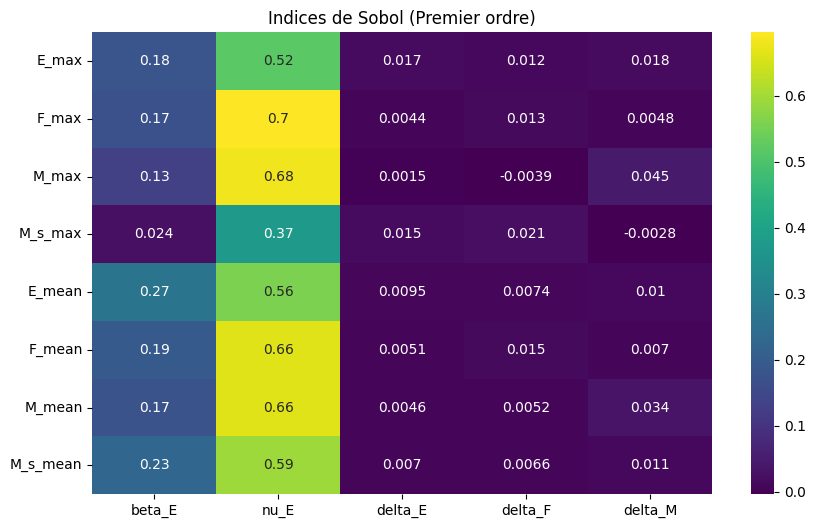

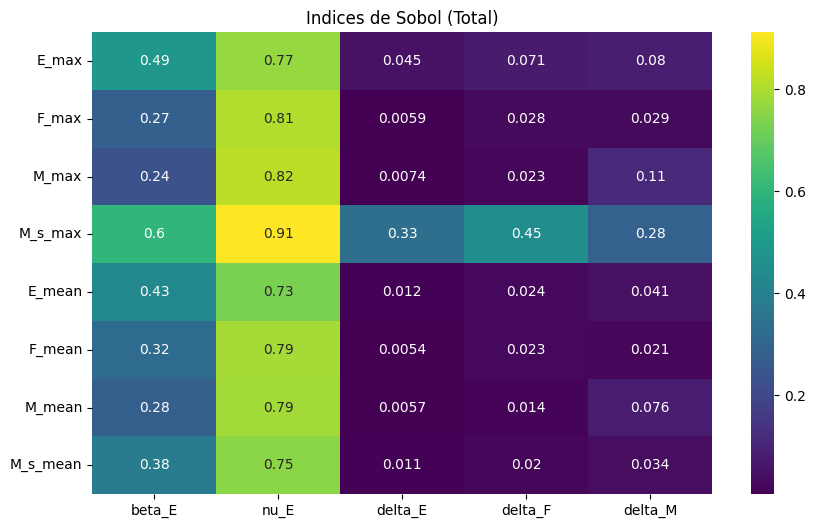

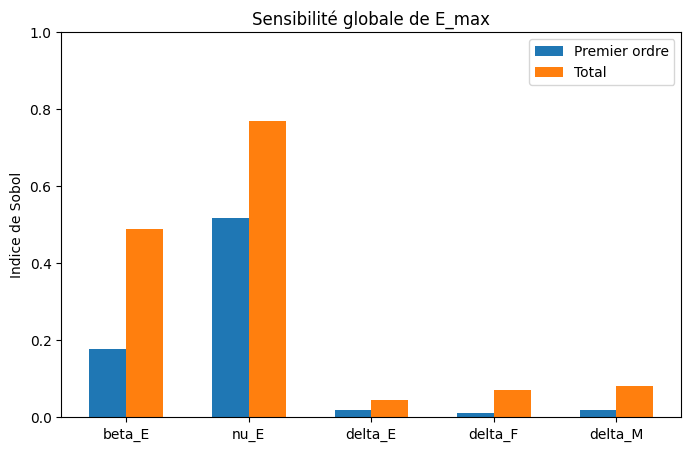

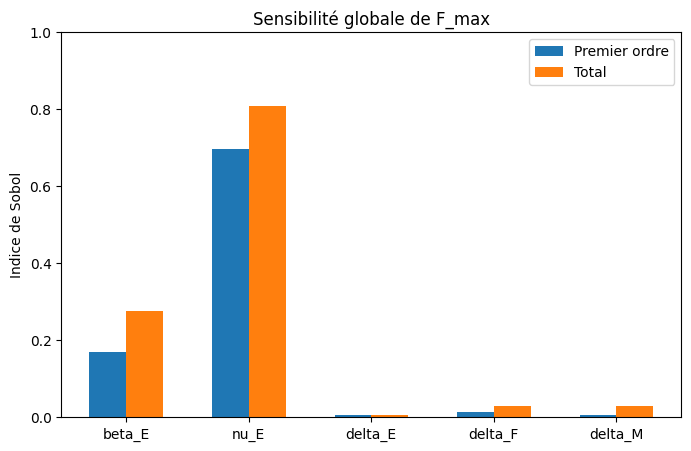

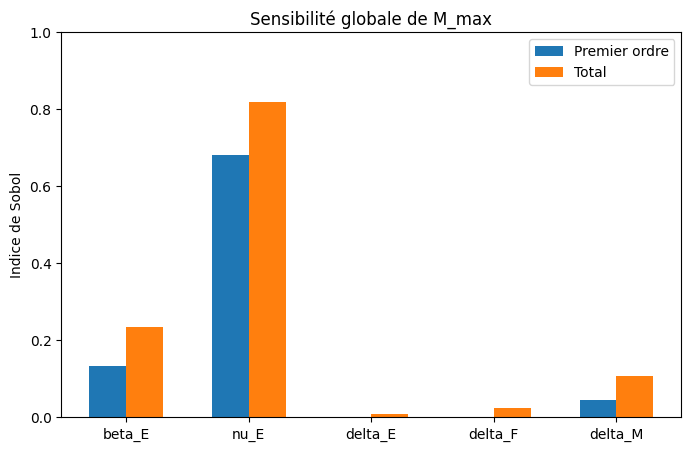

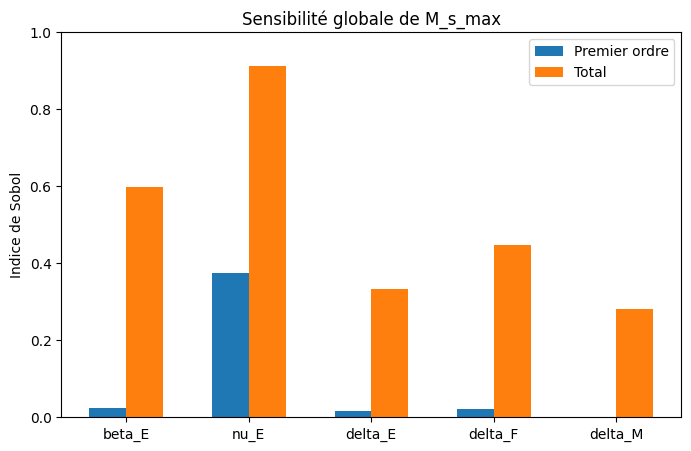

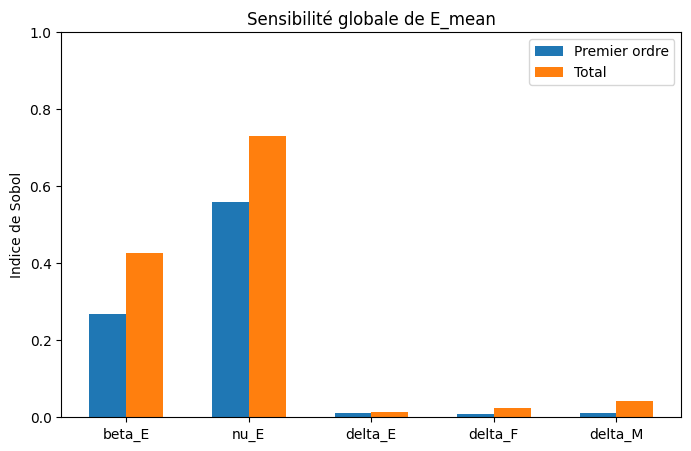

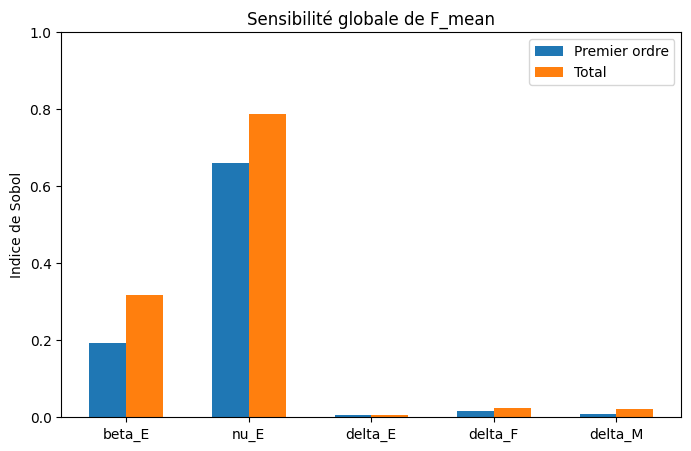

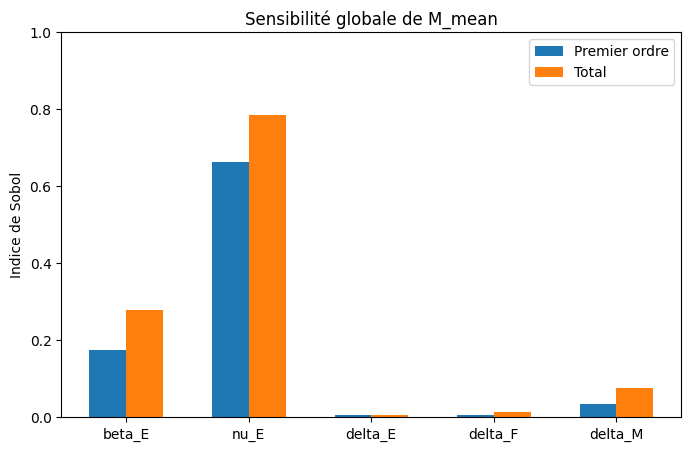

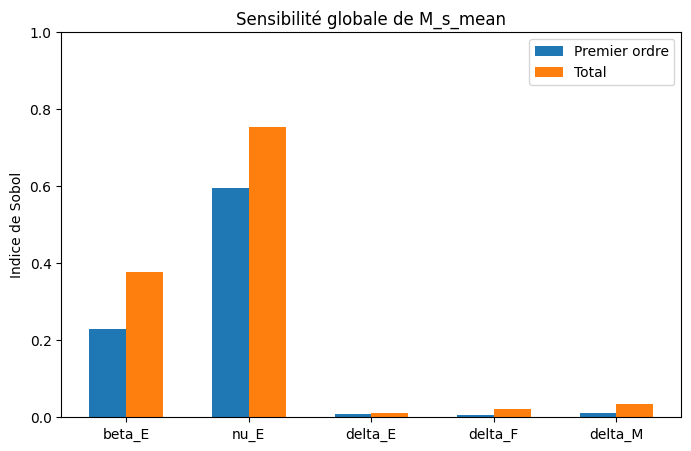

In [3]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from SALib.sample import saltelli
from SALib.analyze import sobol
import seaborn as sns

# -----------------------------
# Paramètres fixes du modèle
# -----------------------------
K = 222000.0       # capacité de charge (exemple)
nu = 0.49       # fraction d'émergence femelle
gamma_s = 1.0  # paramètre saturation
delta_s = 0.12  # décroissance M_s
theta = 220
alpha = 90
beta_s = 1
v = 1000.0        # contrôle constant (peut être modifié)
E0, F0, M0, M_s0 = 10, 5, 5, 0  # conditions initiales

# -----------------------------
# Définir le modèle
# -----------------------------
def mosquito_model(t, y, beta_E, nu_E, delta_E, delta_F, delta_M):
    E, F, M, M_s = y
    dE = beta_E * F * (1 - E / K) - (nu_E + delta_E) * E
    dF = nu * nu_E * E * M / (M + gamma_s * M_s) - delta_F * F
    dM = (1 - nu) * nu_E * E - delta_M * M
    #dM_s = u(E,M,M_s,beta_E, nu_E, delta_E, delta_F, delta_M) - delta_s * M_s
    dM_s = v - delta_s * M_s
    return [dE, dF, dM, dM_s]

# -----------------------------
# Définir le control feedback
# -----------------------------


def u(E, M, M_s,beta_E, nu_E, delta_E, delta_F, delta_M):
    R_0 = beta_E*nu*nu_E/(delta_F*(nu_E+delta_E))

    R_theta = R_0/(1+gamma_s*theta)

    psi = 2*beta_E*nu*nu_E/(delta_F*(1-R_theta)*(1+gamma_s*theta))
    # Petites constantes pour éviter division par zéro


    term1 = (gamma_s * psi * E * (theta*M + M_s)**2) / (
        alpha * (M + gamma_s*M_s) * (3*theta*M + M_s)
    )

    term2 = (((1-nu)*nu_E*theta*E - theta*delta_M*M) * (theta*M + 3*M_s)) / (
        3*theta*M + M_s
    )

    term3 = delta_s * M_s
    term4 = (beta_s/alpha) * (theta*M - M_s)

    Term = max(0,term1 + term2 + term3 + term4)

    return Term


# -----------------------------
# Définir le problème pour Sobol
# -----------------------------
problem = {
    'num_vars': 5,
    'names': ['beta_E', 'nu_E', 'delta_E', 'delta_F', 'delta_M'],
    'bounds': [[7.46, 14.85],
               [0.005, 0.25],
               [0.023, 0.046],
               [0.033, 0.046],
               [0.077, 0.139]]
}

# -----------------------------
# Générer les échantillons Sobol
# -----------------------------
N = 500  # nombre de base, total d'évaluations ~ N*(2D+2)
param_values = saltelli.sample(problem, N, calc_second_order=False)

# -----------------------------
# Simuler le modèle pour chaque jeu de paramètres
# -----------------------------
outputs = {'E_max': [], 'F_max': [], 'M_max': [], 'M_s_max': [],
           'E_mean': [], 'F_mean': [], 'M_mean': [], 'M_s_mean': []}

#outputs = {'E': [], 'F': [], 'M': [], 'M_s': [],'E_max': [], 'F_max': [], 'M_max': [], 'M_s_max': [],
 #          'E_mean': [], 'F_mean': [], 'M_mean': [], 'M_s_mean': []}





for params in param_values:
    sol = solve_ivp(lambda t, y: mosquito_model(t, y, *params), [0, 100], [E0, F0, M0, M_s0])
    #outputs['E'].append(sol.y[0, -1])
    #outputs['F'].append(sol.y[1, -1])
    #outputs['M'].append(sol.y[2, -1])
    #outputs['M_s'].append(sol.y[3, -1])

    E, F, M, M_s = sol.y

    outputs['E_max'].append(np.max(E))
    outputs['F_max'].append(np.max(F))
    outputs['M_max'].append(np.max(M))
    outputs['M_s_max'].append(np.max(M_s))

    outputs['E_mean'].append(np.mean(E))
    outputs['F_mean'].append(np.mean(F))
    outputs['M_mean'].append(np.mean(M))
    outputs['M_s_mean'].append(np.mean(M_s))

# -----------------------------
# Analyse de Sobol pour chaque variable
# -----------------------------
Si_dict = {}
for var in outputs:
    Si_dict[var] = sobol.analyze(problem, np.array(outputs[var]), calc_second_order=False)

S1_matrix = []
ST_matrix = []
labels = list(outputs.keys())

for var in labels:
    S1_matrix.append(Si_dict[var]['S1'])
    ST_matrix.append(Si_dict[var]['ST'])

S1_matrix = np.array(S1_matrix)
ST_matrix = np.array(ST_matrix)

plt.figure(figsize=(10,6))
sns.heatmap(S1_matrix, annot=True, cmap="viridis", xticklabels=problem['names'], yticklabels=labels)
plt.title("Indices de Sobol (Premier ordre)")
plt.show()

plt.figure(figsize=(10,6))
sns.heatmap(ST_matrix, annot=True, cmap="viridis", xticklabels=problem['names'], yticklabels=labels)
plt.title("Indices de Sobol (Total)")
plt.show()

# -----------------------------
# Tracer les indices de Sobol
# -----------------------------
for var in outputs:
    S1 = Si_dict[var]['S1']
    ST = Si_dict[var]['ST']
    indices = np.arange(len(problem['names']))

    plt.figure(figsize=(8,5))
    plt.bar(indices - 0.15, S1, width=0.3, label='Premier ordre')
    plt.bar(indices + 0.15, ST, width=0.3, label='Total')
    plt.xticks(indices, problem['names'])
    plt.ylabel('Indice de Sobol')
    plt.title(f'Sensibilité globale de {var}')
    plt.ylim(0, 1)
    plt.legend()
    plt.show()


In [2]:
pip install

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.9/778.9 kB 15.7 MB/s eta 0:00:00
